# ***Predicting Heart Disease Risk Using Bayesian Networks***


---



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install pgmpy

In [ ]:
#Import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import operator
from functools import reduce
from IPython.core.display import display, HTML
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator
from pgmpy.factors.discrete import TabularCPD, State
from pgmpy.inference import VariableElimination
from pgmpy.sampling import BayesianModelSampling
from pgmpy.independencies import Independencies, IndependenceAssertion
%matplotlib inline

In [ ]:

# Load and preview the dataset
data = pd.read_csv('//content/drive/MyDrive/heart.csv')
print('Number of rows and columns: {}'.format(data.shape))
data.head()




Number of rows and columns: (1025, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


This dataset contains medical records of patients, including demographic information (age, sex), clinical measurements (cholesterol level, maximum heart rate, exercise-induced angina), and diagnostic test results. The data is used to investigate the influence of these factors on the presence or absence of heart disease.

In [ ]:

# Print all the columns of the dataset
print(data.columns.values)

['age' 'sex' 'cp' 'trestbps' 'chol' 'fbs' 'restecg' 'thalach' 'exang'
 'oldpeak' 'slope' 'ca' 'thal' 'target']


For this project, we have selected seven key features — age, sex, chest pain type (cp), cholesterol level (chol), maximum heart rate achieved (thalach), exercise-induced angina (exang), and the target (presence of heart disease) — to more accurately assess the risk of heart disease in patients.

In [ ]:
# Select only relevant features from the heart disease dataset
df = data[[
    'age',
    'sex',
    'cp',
    'chol',
    'thalach',
    'exang',
    'target'
]].copy()

df.head(5)


,age,sex,cp,chol,thalach,exang,target
0,52,1,0,212,168,0,0
1,53,1,0,203,155,1,0
2,70,1,0,174,125,1,0
3,61,1,0,203,161,0,0
4,62,0,0,294,106,0,0


Discretization converts continuous numeric variables into categorical bins to simplify analysis and reveal group-level patterns. Here, we discretize key features age, cholesterol level (chol), and maximum heart rate achieved (thalach) to better assess how patient characteristics influence the risk of heart disease.

In [ ]:
# Show value counts for each column
for col in df.columns:
    print(f"Value counts for '{col}':")
    print(df[col].value_counts())
    print("\n")


### **Description and Values of the Features**

**Sex**  
Indicates the patient’s gender.  
- 0 = Female  
- 1 = Male  

**Chest Pain Type (cp)**  
Categorical type of chest pain experienced by the patient.  
- 0 = Typical Angina  
- 1 = Atypical Angina  
- 2 = Non-Anginal Pain  
- 3 = Asymptomatic  

**Exercise Induced Angina (exang)**  
**Angina, in full angina pectoris, is chest pain or pressure, usually caused by insufficient blood flow to the heart muscle**
Whether the patient experiences angina during exercise.  
- 0 = No  
- 1 = Yes  

**Age Group**  
Discretizes the patient’s age into three life-stage categories:  
- Young = patient under 40 years  
- Middle = patient between 40–54 years  
- Older = patient 55 years and above  

**Cholesterol Level**  
Discretizes the patient’s serum cholesterol (mg/dl):  
- Desirable = ≤ 200  
- Borderline = 200–239  
- High = ≥ 240  

**Maximum Heart Rate Achieved (Thalach Level)**  
Discretizes maximum heart rate achieved during stress testing:  
- Low = ≤ 120  
- Medium = 120–159  
- High = ≥ 160  

**Target (Heart Disease Outcome)**  
Indicates whether the patient has heart disease:  
- 0 = No heart disease  
- 1 = Heart disease present


---





---




In [ ]:
def age_group(age):
    if age < 40:
        return 'Young'
    elif age < 55:
        return 'Middle'
    else:
        return 'Older'
df['Age Group'] = df['age'].apply(age_group)
def chol_level(chol):
    if chol < 200:
        return 'Desirable'
    elif chol < 240:
        return 'Borderline'
    else:
        return 'High'
df['Cholesterol Level'] = df['chol'].apply(chol_level)
def thalach_level(thal):
    if thal < 120:
        return 'Low'
    elif thal < 160:
        return 'Medium'
    else:
        return 'High'
df['Thalach Level'] = df['thalach'].apply(thalach_level)
# Create final dataframe with discretized features
df_final = df[[
    'sex',                   # binary
    'cp',                    # categorical chest pain type
    'exang',                 # binary
    'Age Group',             # discretized from age
    'Cholesterol Level',     # discretized from chol
    'Thalach Level',         # discretized from thalach
    'target'                 # outcome variable
]].copy()

df_final.head()


,sex,cp,exang,Age Group,Cholesterol Level,Thalach Level,target
0,1,0,0,Middle,Borderline,High,0
1,1,0,1,Middle,Borderline,Medium,0
2,1,0,1,Older,Desirable,Medium,0
3,1,0,0,Older,Borderline,High,0
4,0,0,0,Older,High,Low,0


### **Defining Network**

The network is defined with the following logic

**Age Group**  
- Directly influences Chest Pain type (cp), reflecting how life stage and physiology can affect symptom presentation.  
- Directly impacts the Target (heart disease), as different age brackets show varying risk levels.  

**Sex**  
- Influences Chest Pain type, since males and females often present differently.  
- Directly affects Target risk, capturing sex-specific prevalence of heart disease.  

**Chest Pain (cp)**  
- Directly impacts Target, as specific types of chest pain are strong indicators of heart disease risk.  

**Cholesterol Level**  
- Influences Target, because elevated cholesterol is a known risk factor.  

**Maximum Heart Rate Achieved (Thalach Level)**  
- Directly affects Target, since lower or abnormal maximum heart rate may signal higher risk.  

**Exercise Induced Angina (exang)**  
- Impacts Target, reflecting how exercise-related symptoms correlate with disease presence.


---



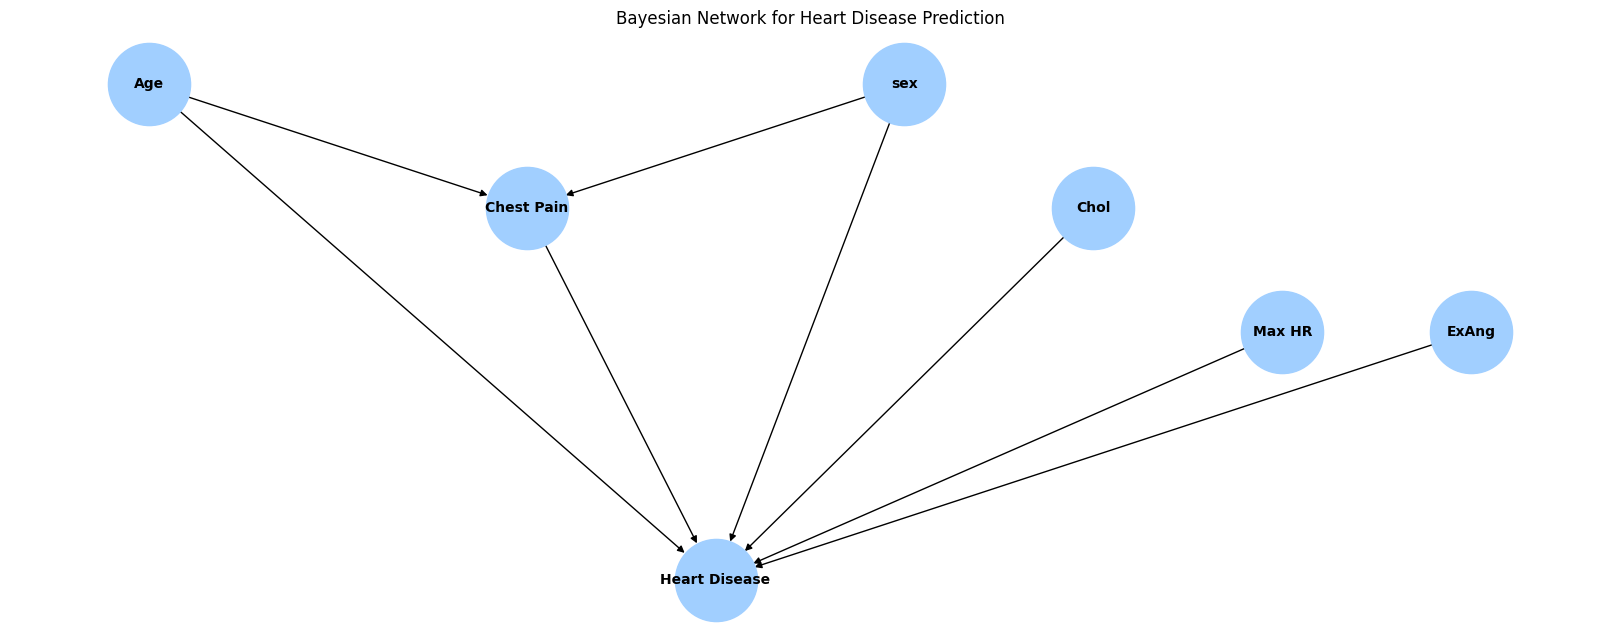

In [ ]:
from pgmpy.models import DiscreteBayesianNetwork
import matplotlib.pyplot as plt
import networkx as nx

# Define the Bayesian Network for heart disease
model = DiscreteBayesianNetwork([
    # Age & Sex influence chest pain and target
    ('Age Group', 'cp'),
    ('Age Group', 'target'),
    ('sex', 'cp'),
    ('sex', 'target'),

    # Chest pain influences target
    ('cp', 'target'),

    # Cholesterol and Thalach influence target
    ('Cholesterol Level', 'target'),
    ('Thalach Level', 'target'),

    # Exercise induced angina influences target
    ('exang', 'target')
])


# rename nodes for nicer visualization
label_map = {
    'Age Group': 'Age',
    'sex': 'sex',
    'cp': 'Chest Pain',
    'Cholesterol Level': 'Chol',
    'Thalach Level': 'Max HR',
    'exang': 'ExAng',
    'target': 'Heart Disease'
}

# Create networkx graph
G = nx.DiGraph()
G.add_edges_from(model.edges())
G = nx.relabel_nodes(G, label_map)
# Further improved positions to separate Age and Chest Pain
pos = {
    'Age': (-2, 2),           # move Age further left
    'sex': (2, 2),            # move Sex further right
    'Chest Pain': (0, 1.5),   # move Chest Pain down slightly
    'Chol': (3, 1.5),
    'Max HR': (4, 1),
    'ExAng': (5, 1),
    'Heart Disease': (1, 0)   # keep Heart Disease central
}

plt.figure(figsize=(16, 6))
nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=3500,
    node_color="#a1cfff",
    font_size=10,
    font_weight="bold",
    arrows=True
)
plt.title("Bayesian Network for Heart Disease Prediction")
plt.axis("off")
plt.show()




### **Structure Learning (Hill Climb with BIC Scoring)**

  0%|          | 0/1000000 [00:00<?, ?it/s]

Learned Edges:
sex → target
sex → Cholesterol Level
target → cp
target → Thalach Level
target → exang
Cholesterol Level → Age Group
cp → exang
exang → Thalach Level
Age Group → target


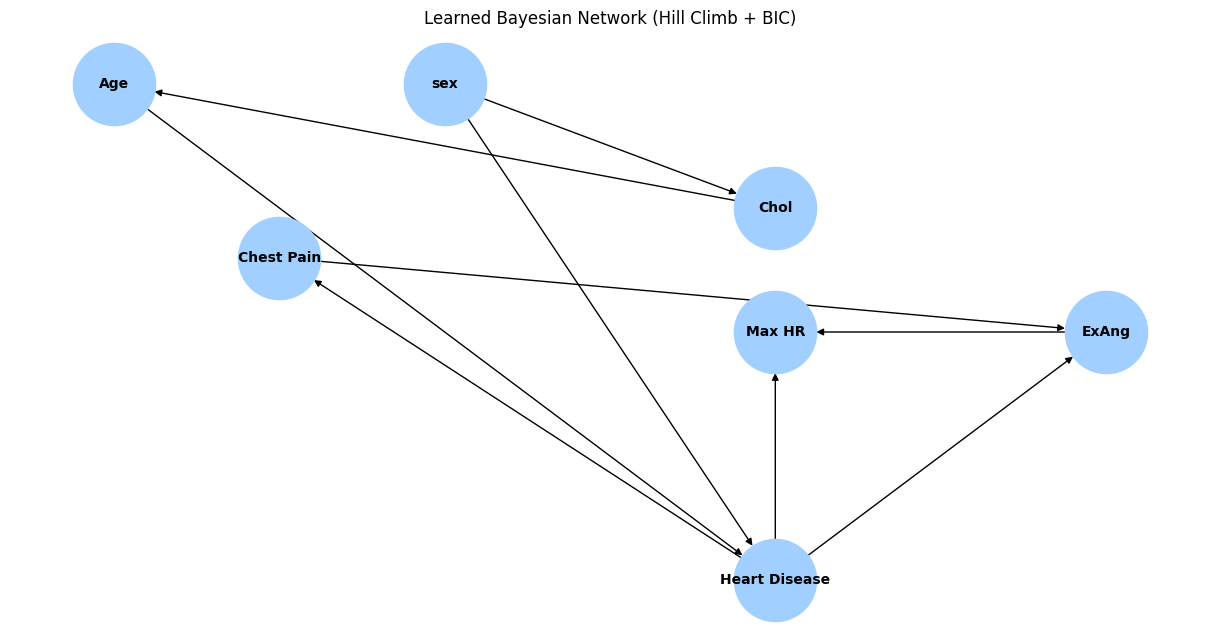

In [ ]:
# ============================================
#   HEART DISEASE STRUCTURE LEARNING (HC + BIC)
#   FULL PIPELINE IN ONE CODE BLOCK
# ============================================

import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

from pgmpy.estimators import HillClimbSearch, BayesianEstimator
from pgmpy.models import DiscreteBayesianNetwork



est = HillClimbSearch(data=df_final)

learned_model = est.estimate(scoring_method="bic-d", show_progress=True)
learned_model = DiscreteBayesianNetwork(learned_model.edges())
print("Learned Edges:")
for u, v in learned_model.edges():
    print(f"{u} → {v}")

# ---------------------------------------------------------
# 3. Node renaming for visualization (same as your manual BN)
# ---------------------------------------------------------
label_map = {
    'Age Group': 'Age',
    'sex': 'sex',
    'cp': 'Chest Pain',
    'Cholesterol Level': 'Chol',
    'Thalach Level': 'Max HR',
    'exang': 'ExAng',
    'target': 'Heart Disease'
}

# ---------------------------------------------------------
# 4. Create graph & relabel nodes
# ---------------------------------------------------------
G = nx.DiGraph()
G.add_edges_from(learned_model.edges())
G = nx.relabel_nodes(G, label_map)

# ---------------------------------------------------------
# 5. Use the SAME positions as your manual BN
# ---------------------------------------------------------
pos = {
    'Age': (0, 2),
    'sex': (1, 2),
    'Chest Pain': (0.5, 1.3),
    'Chol': (2, 1.5),
    'Max HR': (2, 1),
    'ExAng': (3, 1),
    'Heart Disease': (2, 0)
}

# ---------------------------------------------------------
# 6. Plot the learned structure (same style as manual)
# ---------------------------------------------------------
plt.figure(figsize=(12, 6))
nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=3500,
    node_color="#a1cfff",
    font_size=10,
    font_weight="bold",
    arrows=True
)
plt.title("Learned Bayesian Network (Hill Climb + BIC)")
plt.axis("off")
plt.show()



# **Estimating Conditional Probability Tables (CPTs)**

Conditional Probability Tables (CPTs) define the probability of each variable taking on a particular value given every possible combination of its parent variables. They are the core parameters of a Bayesian network, encoding how each node depends on its predecessors. Estimating CPTs from data transforms a qualitative dependency graph into a quantitative model, enabling the computation of joint and conditional probabilities for inference, prediction, and reasoning under uncertainty.

In [ ]:
from pgmpy.estimators import BayesianEstimator
import numpy as np

# Compatibility fix
np.product = np.prod


# ======================================================
#                  MANUAL MODEL CPDs
# ======================================================

print("\n======================")
print(" MANUAL MODEL CPDs")
print("======================\n")

# Clear old CPDs
model.cpds = []

# Fit CPDs for manual model
model.fit(
    data=df_final,
    estimator=BayesianEstimator,
    prior_type="BDeu",
    equivalent_sample_size=10
)

# Check model validity
print("Is manual model valid?", model.check_model(), "\n")

# Print CPDs
for cpd in model.get_cpds():
    print(f"CPT of {cpd.variable}:")
    print(cpd, "\n")



# ======================================================
#              HILL CLIMB LEARNED MODEL CPDs
# ======================================================

print("\n==============================")
print(" HILL CLIMB LEARNED MODEL CPDs")
print("==============================\n")

# Clear old CPDs for learned model
learned_model.cpds = []

# Fit CPDs for learned model
learned_model.fit(
    data=df_final,
    estimator=BayesianEstimator,
    prior_type="BDeu",
    equivalent_sample_size=10
)

#Check model validity
print("Is learned model valid?", learned_model.check_model(), "\n")

# Print CPDs
for cpd in learned_model.get_cpds():
    print(f"CPT of {cpd.variable}:")
    print(cpd, "\n")



 MANUAL MODEL CPDs

Is manual model valid? True 

CPT of Age Group:
+-------------------+-----------+
| Age Group(Middle) | 0.408052  |
+-------------------+-----------+
| Age Group(Older)  | 0.533655  |
+-------------------+-----------+
| Age Group(Young)  | 0.0582931 |
+-------------------+-----------+ 

CPT of cp:
+-----------+----------------------+-----+---------------------+
| Age Group | Age Group(Middle)    | ... | Age Group(Young)    |
+-----------+----------------------+-----+---------------------+
| sex       | sex(0)               | ... | sex(1)              |
+-----------+----------------------+-----+---------------------+
| cp(0)     | 0.26150306748466257  | ... | 0.274               |
+-----------+----------------------+-----+---------------------+
| cp(1)     | 0.26150306748466257  | ... | 0.20199999999999999 |
+-----------+----------------------+-----+---------------------+
| cp(2)     | 0.4731595092024539   | ... | 0.34600000000000003 |
+-----------+-----------------

In [ ]:
# Grab the Target CPD in Manual network
cpd = next(c for c in model.get_cpds() if c.variable == "target")

# Check the shape
var_card    = cpd.variable_card      # e.g. 3
parent_cards = [model.get_cardinality(p) for p in cpd.get_evidence()]
expected_columns = reduce(operator.mul, parent_cards, 1)
flat = cpd.values.reshape(var_card, -1)

# Check each column sums to 1
col_sums = flat.sum(axis=0)
bad_cols = [i for i, s in enumerate(col_sums) if abs(s - 1.0) > 1e-8]

if not bad_cols:
    print("All", expected_columns, "columns sum to 1")
else:
    print(f" Columns {bad_cols[:10]} (of {expected_columns}) sum ≠ 1")
    print("First few sums:", col_sums[:10])

All 432 columns sum to 1


## **Network Analysis**

Below we perform a series of checks and queries to validate our Bayesian Network.

**DAG Acyclicity**  
A Bayesian Network must form a Directed Acyclic Graph (DAG), i.e., a directed graph with no cycles. This ensures a valid factorization of the joint probability distribution.

**Global Independence Assertions**  
The DAG structure of a Bayesian Network implies a set of conditional independence statements of the form *I(X, Y | Z)*, meaning “X is independent of Y given Z.” These global assertions capture every independence implied by the graph’s topology.

**Local (Markov) Semantics**  
The local Markov property states that each node is conditionally independent of its non-descendants once its direct parents are known. After accounting for a node’s parents, no other variables outside its ancestral line provide additional information about it.

**Active Trails and d-Separation**  
- An **active trail** is a path through the DAG along which probabilistic influence can flow, given a set of observed (evidence) variables.  
- **d-Separation** defines when two nodes are independent: if every path between them is “blocked” by the evidence (i.e., no active trails remain), they are conditionally independent. Conversely, if at least one active trail exists, information can pass, and the nodes are dependent under the given evidence.

**Markov Blanket**  
The Markov blanket of a node is the minimal set (its parents, children, and its children’s other parents) that makes it independent of all other variables.

**Assertion Frequency Analysis**  
By counting how often each variable appears as the “independent” side or within the evidence set across all assertions, we assess which nodes are most structurally central in driving independencies.

**Sample Assertion Checks**  
We rigorously test specific conditional-independence hypotheses by creating `IndependenceAssertion(X, Y | Z)` objects, formalizing “X is independent of Y given Z,” and confirming they appear in the network’s global set of implied independencies. This targeted validation ensures our learned DAG faithfully encodes the intended dependency structure and serves as a robust sanity check of its conditional independence properties.


## **Doing Network Analysis of Our Manual Defined Network**

In [ ]:
from pgmpy.independencies import IndependenceAssertion

# 1. Check acyclicity
print("Is DAG:", model.check_model())  # True if no cycles and CPDs sum to 1

# All conditional independence assertions
all_assertions = model.get_independencies().get_assertions()
print(f"Total independence assertions: {len(all_assertions)}\n")

# Local (Markov) semantics: each node ⟂ non-descendants | parents
print("Local independencies (node ⟂ non-descendants | parents):")
for node in model.nodes():
    print(f"  {node:15s} ⟂ NonDesc | Parents = {model.local_independencies(node)}")
print()

# Active trails: given some evidence, which other nodes remain connected?
def show_active_trails(query, evidence):
    active = set(model.active_trail_nodes(query, observed=evidence).get(query, []))
    active.discard(query)
    if evidence:
        print(f"Active trails from '{query}' given evidence={evidence}: {active}")
    else:
        print(f"Active trails from '{query}' with no evidence: {active}")

# Example calls
show_active_trails('target', evidence=[])
show_active_trails('target', evidence=['cp'])
show_active_trails('target', evidence=['sex', 'Age Group'])
print()

# Markov blanket of key nodes
print("Markov blankets:")
for node in ['target', 'cp', 'Age Group', 'Thalach Level']:
    print(f"  {node:15s} → {model.get_markov_blanket(node)}")
print()

# Count how often nodes appear as independent variables vs. evidence in assertions
nodes = list(model.nodes())
def count_event1(n): return sum(1 for a in all_assertions if n in a.event1)
def count_event3(n): return sum(1 for a in all_assertions if n in a.event3)

indep_scores = {n: count_event1(n) for n in nodes}
evid_scores  = {n: count_event3(n) for n in nodes}

max_indep = max(indep_scores.values()); min_indep = min(indep_scores.values())
max_evid  = max(evid_scores.values());  min_evid  = min(evid_scores.values())

print(f"Nodes most often independent-vars ({max_indep} times):",
      [n for n,s in indep_scores.items() if s==max_indep])
print(f"Nodes least often independent-vars ({min_indep} times):",
      [n for n,s in indep_scores.items() if s==min_indep])
print(f"Nodes most often evidence ({max_evid} times):",
      [n for n,s in evid_scores.items() if s==max_evid])
print(f"Nodes least often evidence ({min_evid} times):",
      [n for n,s in evid_scores.items() if s==min_evid])
print()

# Quick checks of specific assertions
def check_assertion(independent, dependent, evidence):
    a = IndependenceAssertion(independent, dependent, evidence)
    ok = any(
        frozenset(a.event1)==ass.event1
        and a.event2.issubset(ass.event2)
        and frozenset(a.event3)==ass.event3
        for ass in all_assertions
    )
    print(f"{a} --> {ok}")

print("Sample assertion checks:")
check_assertion(['Age Group'], ['cp'], [])
check_assertion(['target'], ['Age Group'], ['cp'])
check_assertion(['sex'], ['target'], [])
check_assertion(['Thalach Level'], ['target'], ['cp'])
check_assertion(['Age Group'], ['Thalach Level'], [])


Is DAG: True
Total independence assertions: 13

Local independencies (node ⟂ non-descendants | parents):
  Age Group       ⟂ NonDesc | Parents = (Age Group ⟂ Cholesterol Level, sex, exang, Thalach Level)
  cp              ⟂ NonDesc | Parents = (cp ⟂ Thalach Level, exang, Cholesterol Level | sex, Age Group)
  target          ⟂ NonDesc | Parents = 
  sex             ⟂ NonDesc | Parents = (sex ⟂ Cholesterol Level, Age Group, exang, Thalach Level)
  Cholesterol Level ⟂ NonDesc | Parents = (Cholesterol Level ⟂ Age Group, Thalach Level, sex, exang, cp)
  Thalach Level   ⟂ NonDesc | Parents = (Thalach Level ⟂ Age Group, Cholesterol Level, sex, exang, cp)
  exang           ⟂ NonDesc | Parents = (exang ⟂ Age Group, Cholesterol Level, Thalach Level, sex, cp)

Active trails from 'target' with no evidence: {'Age Group', 'Thalach Level', 'Cholesterol Level', 'exang', 'sex', 'cp'}
Active trails from 'target' given evidence=['cp']: {'Age Group', 'Thalach Level', 'Cholesterol Level', 'exang', 'sex'}
A

## **Doing Network Analysis of Our Hill-Climb Learned Network**

In [ ]:
from pgmpy.independencies import IndependenceAssertion

# 1. Check acyclicity
print("Is DAG:", learned_model.check_model())  # True if no cycles and CPDs sum to 1

# All conditional independence assertions
all_assertions = learned_model.get_independencies().get_assertions()
print(f"Total independence assertions: {len(all_assertions)}\n")

# Local (Markov) semantics: each node ⟂ non-descendants | parents
print("Local independencies (node ⟂ non-descendants | parents):")
for node in learned_model.nodes():
    print(f"  {node:15s} ⟂ NonDesc | Parents = {learned_model.local_independencies(node)}")
print()

# Active trails: given some evidence, which other nodes remain connected?
def show_active_trails(query, evidence):
    active = set(learned_model.active_trail_nodes(query, observed=evidence).get(query, []))
    active.discard(query)
    if evidence:
        print(f"Active trails from '{query}' given evidence={evidence}: {active}")
    else:
        print(f"Active trails from '{query}' with no evidence: {active}")

# Example calls
show_active_trails('target', evidence=[])
show_active_trails('target', evidence=['cp'])
show_active_trails('target', evidence=['sex', 'Age Group'])
print()

# Markov blanket of key nodes
print("Markov blankets:")
for node in ['target', 'cp', 'Age Group', 'Thalach Level']:
    print(f"  {node:15s} → {learned_model.get_markov_blanket(node)}")
print()

# Count how often nodes appear as independent variables vs. evidence in assertions
nodes = list(learned_model.nodes())
def count_event1(n): return sum(1 for a in all_assertions if n in a.event1)
def count_event3(n): return sum(1 for a in all_assertions if n in a.event3)

indep_scores = {n: count_event1(n) for n in nodes}
evid_scores  = {n: count_event3(n) for n in nodes}

max_indep = max(indep_scores.values()); min_indep = min(indep_scores.values())
max_evid  = max(evid_scores.values());  min_evid  = min(evid_scores.values())

print(f"Nodes most often independent-vars ({max_indep} times):",
      [n for n,s in indep_scores.items() if s==max_indep])
print(f"Nodes least often independent-vars ({min_indep} times):",
      [n for n,s in indep_scores.items() if s==min_indep])
print(f"Nodes most often evidence ({max_evid} times):",
      [n for n,s in evid_scores.items() if s==max_evid])
print(f"Nodes least often evidence ({min_evid} times):",
      [n for n,s in evid_scores.items() if s==min_evid])
print()

# Quick checks of specific assertions
def check_assertion(independent, dependent, evidence):
    a = IndependenceAssertion(independent, dependent, evidence)
    ok = any(
        frozenset(a.event1)==ass.event1
        and a.event2.issubset(ass.event2)
        and frozenset(a.event3)==ass.event3
        for ass in all_assertions
    )
    print(f"{a} --> {ok}")

print("Sample assertion checks:")
check_assertion(['Age Group'], ['cp'], [])
check_assertion(['target'], ['Age Group'], ['cp'])
check_assertion(['sex'], ['target'], [])
check_assertion(['Thalach Level'], ['target'], ['cp'])
check_assertion(['Age Group'], ['Thalach Level'], [])


Is DAG: True
Total independence assertions: 12

Local independencies (node ⟂ non-descendants | parents):
  sex             ⟂ NonDesc | Parents = 
  target          ⟂ NonDesc | Parents = (target ⟂ Cholesterol Level | sex, Age Group)
  Cholesterol Level ⟂ NonDesc | Parents = 
  cp              ⟂ NonDesc | Parents = (cp ⟂ sex, Age Group, Cholesterol Level | target)
  exang           ⟂ NonDesc | Parents = (exang ⟂ sex, Age Group, Cholesterol Level | cp, target)
  Thalach Level   ⟂ NonDesc | Parents = (Thalach Level ⟂ sex, Age Group, cp, Cholesterol Level | exang, target)
  Age Group       ⟂ NonDesc | Parents = (Age Group ⟂ sex | Cholesterol Level)

Active trails from 'target' with no evidence: {'Age Group', 'Cholesterol Level', 'Thalach Level', 'exang', 'sex', 'cp'}
Active trails from 'target' given evidence=['cp']: {'Age Group', 'Cholesterol Level', 'Thalach Level', 'exang', 'sex'}
Active trails from 'target' given evidence=['sex', 'Age Group']: {'exang', 'cp', 'Thalach Level'}

Markov bl

### **Inferring the Fitted Bayesian Networks**

The Bayesian network can now be used to answer questions regarding the probability of certain outcomes given observed evidence. In our case, we are interested in predicting heart disease outcomes based on patient features. This inference can be performed using two alternative methods: **exact inference** via Variable Elimination or **approximate inference** via Likelihood Weighted Sampling.

#### **Variable Elimination (VE)**

Variable Elimination is an exact inference technique for Bayesian networks that computes the posterior \(P(Q | evidence)) by systematically removing irrelevant variables. It begins by incorporating the observed evidence, restricting each conditional probability table (CPT) to the known values. The resulting factors are then multiplied to form joint distributions over the remaining variables. Next, hidden (non-query) variables are eliminated one at a time by summing them out of these intermediate factors. Finally, the remaining factor, defined solely over the query variable, is normalized so that its probabilities sum to one, yielding the exact posterior distribution of the query variable given the observed evidence.


In [ ]:
# Define the inference function using variable elimination
def varElim(model_para,Q, evidence):
    infer = VariableElimination(model_para)

    string = ''
    lst = list(evidence.items())
    last = len(lst) - 1

    for i, pair in enumerate(lst):
        string += pair[0] + '=' + str(pair[1])
        if i != last:
            string += ', '

    prob = infer.query([Q], evidence=evidence, show_progress=False)
    val = prob.values

    print('Probability of {} given {}\n'.format(Q, string))
    print(prob)


#### **Likelihood Weighted Sampling**

Likelihood Weighted Sampling is an approximate inference method for Bayesian networks that estimates the posterior distribution \(P(Q | evidence)\) by generating samples consistent with the observed evidence. In each sample, the evidence variables are fixed to their observed values, while the non-evidence variables are sampled according to their conditional probabilities. Each sample is assigned a weight equal to the product of the probabilities of the evidence variables given their sampled parents. After generating a large number of weighted samples, the posterior distribution of the query variable \(Q\) is approximated by normalizing the sum of weights for samples where \(Q\) takes each possible value. This method concentrates computational effort on regions of the sample space consistent with the evidence, making it more efficient than naive random sampling.


In [ ]:
# Define the inference function using likelihood weighted sampling
def sampLW(model_para,Q, evidence, sample_size):
    infer = BayesianModelSampling(model_para)

    samples = infer.likelihood_weighted_sample(evidence=evidence, size=sample_size, seed=0)

    unique = samples[Q].unique()
    unique.sort()

    string = ''
    last = len(evidence) - 1
    for i, pair in enumerate(evidence):
        string += pair[0] + '=' + str(pair[1])
        if i != last:
            string += ', '

    print('Probability of {} given {}\n'.format(Q, string))

    prob_lst = []
    for val in unique:
        rows = samples[samples[Q] == val]

        numerator = np.sum(rows['_weight'])
        denominator = np.sum(samples['_weight'])
        prob = round(numerator/denominator, 4)

        prob_lst.append(prob)

        print('{}({}) = {}'.format(Q, val, prob))

# **Probabilistic Inference Queries**


---



**1) What is the likelihood of heart disease among older individuals?**

This  query asks for the predictive probability that a patient has heart disease given that they are above 50 years old

In [ ]:

# =========================================
# Define evidence
# =========================================
evidence_dict = {'Age Group': 'Older'}
evidence_states = [State('Age Group', 'Older')]

# =========================================
# Manual Model Inference
# =========================================
print("### Manual Network Inference ###\n")
varElim(model, 'target', evidence_dict)
sampLW(model, 'target', evidence_states, sample_size=10000)

# =========================================
# Hill-Climb Learned Model Inference
# =========================================
print("### Hill-Climb Learned Network Inference ###\n")
varElim(learned_model, 'target', evidence_dict)
sampLW(learned_model, 'target', evidence_states, sample_size=10000)



### Manual Network Inference ###

Probability of target given Age Group=Older

+-----------+---------------+
| target    |   phi(target) |
+===========+===============+
| target(0) |        0.6236 |
+-----------+---------------+
| target(1) |        0.3764 |
+-----------+---------------+


  0%|          | 0/7 [00:00<?, ?it/s]

Probability of target given Age Group=Older

target(0) = 0.626
target(1) = 0.374
### Hill-Climb Learned Network Inference ###

Probability of target given Age Group=Older

+-----------+---------------+
| target    |   phi(target) |
+===========+===============+
| target(0) |        0.6296 |
+-----------+---------------+
| target(1) |        0.3704 |
+-----------+---------------+


  0%|          | 0/7 [00:00<?, ?it/s]

Probability of target given Age Group=Older

target(0) = 0.6265
target(1) = 0.3735


The probability of heart disease is moderately elevated for older patients, with about 37% affected. Age-related physiological changes and accumulated lifestyle risk factors contribute to a higher likelihood of developing heart disease in this group.Both the manual network and the Hill-Climb learned network produce very similar predictions, confirming consistency between expert-defined and data-driven models.

**2)How likely is a patient to have heart disease if they are male?**

This predictive query asks for the predictive probability that a patient has heart disease given that they are male

In [ ]:
# Predictive: age
evidence_dict = {'sex': 1}
evidence_states = [State('sex',1)]

# Using manual model
print("### Manual Network Inference ###\n")
varElim(model, 'target', evidence_dict)
sampLW(model, 'target', evidence_states, sample_size=10000)
# =========================================
# Hill-Climb Learned Model Inference
# =========================================
print("### Hill-Climb Learned Network Inference ###\n")
varElim(learned_model, 'target', evidence_dict)
sampLW(learned_model, 'target', evidence_states, sample_size=10000)


### Manual Network Inference ###

Probability of target given sex=1

+-----------+---------------+
| target    |   phi(target) |
+===========+===============+
| target(0) |        0.5900 |
+-----------+---------------+
| target(1) |        0.4100 |
+-----------+---------------+


  0%|          | 0/7 [00:00<?, ?it/s]

Probability of target given sex=1

target(0) = 0.5902
target(1) = 0.4098
### Hill-Climb Learned Network Inference ###

Probability of target given sex=1

+-----------+---------------+
| target    |   phi(target) |
+===========+===============+
| target(0) |        0.5852 |
+-----------+---------------+
| target(1) |        0.4148 |
+-----------+---------------+


  0%|          | 0/7 [00:00<?, ?it/s]

Probability of target given sex=1

target(0) = 0.5829
target(1) = 0.4171


Male patients show a higher risk of heart disease, with around 41% affected. Biological differences, prevalence patterns, and potentially lifestyle factors make being male a notable contributing factor.Both the manual network and the Hill-Climb learned network produce very similar predictions, confirming consistency between expert-defined and data-driven models.

**3) If a patient has heart disease, what’s the chance they had high cholesterol?**

This diagnostic query asks for the diagnostic probability that a patient had high cholesterol given that they already have heart disease .

In [ ]:
evidence_dict = {'target': 1}
evidence_states = [State('target', 1)]

# Manual Network
print("### Manual Network Inference ###\n")
varElim(model, 'Cholesterol Level', evidence_dict)
sampLW(model, 'Cholesterol Level', evidence_states, sample_size=10000)

# =========================================
# Hill-Climb Learned Model Inference
# =========================================
print("### Hill-Climb Learned Network Inference ###\n")
varElim(learned_model,  'Cholesterol Level', evidence_dict)
sampLW(learned_model,  'Cholesterol Level', evidence_states, sample_size=10000)


### Manual Network Inference ###

Probability of Cholesterol Level given target=1

+-------------------------------+--------------------------+
| Cholesterol Level             |   phi(Cholesterol Level) |
+===============================+==========================+
| Cholesterol Level(Borderline) |                   0.3776 |
+-------------------------------+--------------------------+
| Cholesterol Level(Desirable)  |                   0.1663 |
+-------------------------------+--------------------------+
| Cholesterol Level(High)       |                   0.4561 |
+-------------------------------+--------------------------+


  0%|          | 0/7 [00:00<?, ?it/s]

Probability of Cholesterol Level given target=1

Cholesterol Level(Borderline) = 0.375
Cholesterol Level(Desirable) = 0.1655
Cholesterol Level(High) = 0.4594
### Hill-Climb Learned Network Inference ###

Probability of Cholesterol Level given target=1

+-------------------------------+--------------------------+
| Cholesterol Level             |   phi(Cholesterol Level) |
+===============================+==========================+
| Cholesterol Level(Borderline) |                   0.3239 |
+-------------------------------+--------------------------+
| Cholesterol Level(Desirable)  |                   0.1768 |
+-------------------------------+--------------------------+
| Cholesterol Level(High)       |                   0.4993 |
+-------------------------------+--------------------------+


  0%|          | 0/7 [00:00<?, ?it/s]

Probability of Cholesterol Level given target=1

Cholesterol Level(Borderline) = 0.3267
Cholesterol Level(Desirable) = 0.1775
Cholesterol Level(High) = 0.4959


Both the manual and Hill-Climb learned networks indicate that high cholesterol is the most common condition among patients with heart disease, with borderline levels also notable, confirming cholesterol’s critical role in disease risk

**4) If a male patient has heart disease, how does this influence the likelihood of high cholesterol?**

This query asks for the intercausal probability (explaining away): how knowing that a patient has heart disease (target=1) and is male (sex=1) changes the likelihood that they also have high cholesterol.

In [ ]:
evidence_dict = {'target': 1, 'sex': 1}
evidence_states = [State('target', 1), State('sex', 1)]

# Manual Network
print("### Manual Network Inference ###\n")
varElim(model, 'Cholesterol Level', evidence_dict)
sampLW(model, 'Cholesterol Level', evidence_states, sample_size=10000)

# =========================================
# Hill-Climb Learned Model Inference
# =========================================
print("### Hill-Climb Learned Network Inference ###\n")
varElim(learned_model,  'Cholesterol Level', evidence_dict)
sampLW(learned_model,  'Cholesterol Level', evidence_states, sample_size=10000)



### Manual Network Inference ###

Probability of Cholesterol Level given target=1, sex=1

+-------------------------------+--------------------------+
| Cholesterol Level             |   phi(Cholesterol Level) |
+===============================+==========================+
| Cholesterol Level(Borderline) |                   0.3995 |
+-------------------------------+--------------------------+
| Cholesterol Level(Desirable)  |                   0.1717 |
+-------------------------------+--------------------------+
| Cholesterol Level(High)       |                   0.4287 |
+-------------------------------+--------------------------+


  0%|          | 0/7 [00:00<?, ?it/s]

Probability of Cholesterol Level given target=1, sex=1

Cholesterol Level(Borderline) = 0.4117
Cholesterol Level(Desirable) = 0.1681
Cholesterol Level(High) = 0.4202
### Hill-Climb Learned Network Inference ###

Probability of Cholesterol Level given target=1, sex=1

+-------------------------------+--------------------------+
| Cholesterol Level             |   phi(Cholesterol Level) |
+===============================+==========================+
| Cholesterol Level(Borderline) |                   0.3735 |
+-------------------------------+--------------------------+
| Cholesterol Level(Desirable)  |                   0.1921 |
+-------------------------------+--------------------------+
| Cholesterol Level(High)       |                   0.4344 |
+-------------------------------+--------------------------+


  0%|          | 0/7 [00:00<?, ?it/s]

Probability of Cholesterol Level given target=1, sex=1

Cholesterol Level(Borderline) = 0.3732
Cholesterol Level(Desirable) = 0.1998
Cholesterol Level(High) = 0.427


For male patients with heart disease, ~42–43% have high cholesterol, ~37–41% have borderline cholesterol, and ~17–20% have desirable cholesterol. Both manual and learned networks agree, highlighting cholesterol’s critical role in disease risk

**5) For older patients with heart disease, how likely is it that they have high cholesterol?**

This query asks for the intercausal probability (explaining away): how knowing that a patient has heart disease (target=1) and is older (age>50) changes the likelihood that they also have high cholesterol.


In [ ]:
evidence_dict = {'target': 1, 'Age Group': 'Older'}
evidence_states = [State('target', 1), State('Age Group','Older')]

# Manual Network
print("### Manual Network Inference ###\n")
varElim(model, 'Cholesterol Level', evidence_dict)
sampLW(model, 'Cholesterol Level', evidence_states, sample_size=10000)

# =========================================
# Hill-Climb Learned Model Inference
# =========================================
print("### Hill-Climb Learned Network Inference ###\n")
varElim(learned_model,  'Cholesterol Level', evidence_dict)
sampLW(learned_model,  'Cholesterol Level', evidence_states, sample_size=10000)


### Manual Network Inference ###

Probability of Cholesterol Level given target=1, Age Group=Older

+-------------------------------+--------------------------+
| Cholesterol Level             |   phi(Cholesterol Level) |
+===============================+==========================+
| Cholesterol Level(Borderline) |                   0.3993 |
+-------------------------------+--------------------------+
| Cholesterol Level(Desirable)  |                   0.1992 |
+-------------------------------+--------------------------+
| Cholesterol Level(High)       |                   0.4015 |
+-------------------------------+--------------------------+


  0%|          | 0/7 [00:00<?, ?it/s]

Probability of Cholesterol Level given target=1, Age Group=Older

Cholesterol Level(Borderline) = 0.4093
Cholesterol Level(Desirable) = 0.1915
Cholesterol Level(High) = 0.3992
### Hill-Climb Learned Network Inference ###

Probability of Cholesterol Level given target=1, Age Group=Older

+-------------------------------+--------------------------+
| Cholesterol Level             |   phi(Cholesterol Level) |
+===============================+==========================+
| Cholesterol Level(Borderline) |                   0.2867 |
+-------------------------------+--------------------------+
| Cholesterol Level(Desirable)  |                   0.1225 |
+-------------------------------+--------------------------+
| Cholesterol Level(High)       |                   0.5908 |
+-------------------------------+--------------------------+


  0%|          | 0/7 [00:00<?, ?it/s]

Probability of Cholesterol Level given target=1, Age Group=Older

Cholesterol Level(Borderline) = 0.292
Cholesterol Level(Desirable) = 0.1239
Cholesterol Level(High) = 0.5842


For older patients with heart disease, ~40–58% have high cholesterol, ~29–41% have borderline cholesterol, and ~12–19% have desirable cholesterol. Both manual and learned networks highlight the critical role of elevated cholesterol, with the learned model placing greater emphasis on high cholesterol.

# **Conclusion**

This project demonstrated how a manually constructed Bayesian network can be used to predict heart disease risk and reason about its contributing factors through predictive, diagnostic, and intercausal queries. By integrating key demographic and clinical variables, the manual model highlighted meaningful patterns—such as the elevated risk observed in male and older patients, and the strong association between high or borderline cholesterol and heart disease.

The Hill-Climb learned network provided a data-driven perspective, confirming many of the patterns captured by the manual network. Probabilities derived from the learned model were largely consistent with the expert-defined network, reinforcing the validity of the manually encoded relationships. Minor differences reflect data-specific trends and the effect of structure learning and CPD estimation, offering additional insights into underlying dependencies.

Overall, this approach demonstrates a transparent and effective framework for understanding heart disease risk, combining expert knowledge with data-driven learning. Future improvements could include the incorporation of more variables, refined discretization strategies, and further expert input to enhance model accuracy and predictive power.



---

